# Loading and Visualize ECoG Signal Test

Loading in the matlab file for the first patient, first conversation and visualizing the ECOG signal.

In [1]:
import os
import scipy
import matplotlib.pyplot as plt
import numpy as np
import mne

In [2]:
# directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY661_111_Part1_conversation1/preprocessed_all/NY661_111_Part1_conversation1_electrode_preprocess_file_1.mat"
#preprocessed_directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/preprocessed_all/NY717_111_Part1_conversation1_electrode_preprocess_file_10.mat"
directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw/NY717_111_Part1_conversation1_electrode_raw_file_10.mat"
mat = scipy.io.loadmat(directory)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Nov 25 17:33:34 2019',
 '__version__': '1.0',
 '__globals__': [],
 'electrode_data': array([[-54.63067063, -54.09898528, -54.36482795, ...,  31.23651484,
          42.40190738,  54.89651331]])}

In [3]:
# ecog_signal = mat['p1st']  # for preprocessed
ecog_signal = mat['electrode_data'].ravel()  # for raw
ecog_signal

array([-54.63067063, -54.09898528, -54.36482795, ...,  31.23651484,
        42.40190738,  54.89651331])

In [4]:
ecog_signal.shape

(921601,)

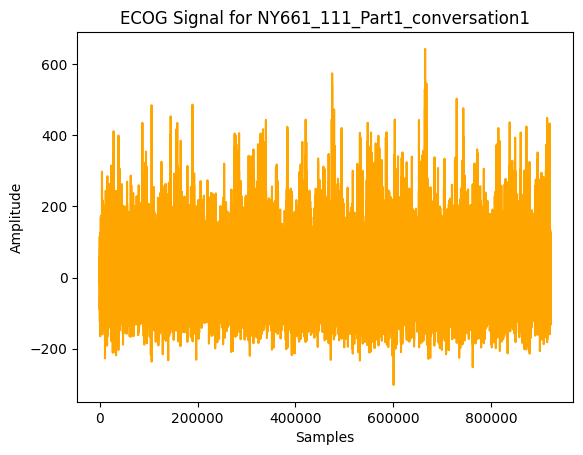

In [5]:
plt.plot(ecog_signal, color='orange')
plt.title('ECOG Signal for NY661_111_Part1_conversation1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [209]:
ecog_signal.shape

(921601,)

In [213]:
# directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY661_111_Part1_conversation1/preprocessed_all/NY661_111_Part1_conversation1_electrode_preprocess_file_1.mat"
#preprocessed_directory = "/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/preprocessed_all/NY717_111_Part1_conversation1_electrode_preprocess_file_10.mat"
subject = 717
electrodes = [10, 27]
ecog_data = []
for elec in electrodes:
    filename = f"/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY{subject}_111_Part1_conversation1/raw/NY{subject}_111_Part1_conversation1_electrode_raw_file_{elec}.mat"
    mat = scipy.io.loadmat(filename)['electrode_data']
    ecog_data.append(mat)

In [216]:
ecog_data = np.vstack(ecog_data)
ecog_data.shape

(2, 921601)

In [225]:
# create mne raw object using np array
sfreq = 512
info = mne.create_info(ch_names=[f'ECoG_{i}' for i in range(len(ecog_data))],sfreq=sfreq, ch_types=['ecog']*len(ecog_data))
raw = mne.io.RawArray(ecog_data, info)

Creating RawArray with float64 data, n_channels=2, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


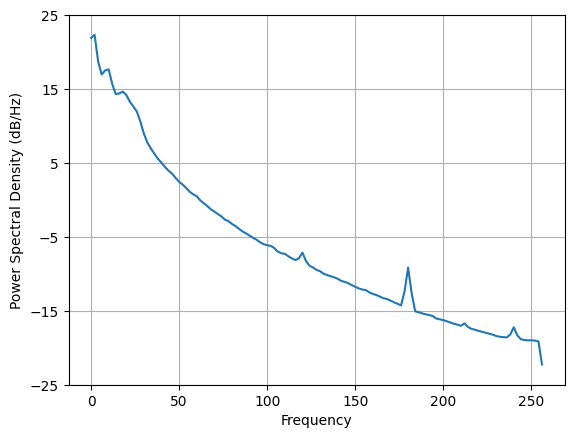

In [226]:
plt.psd(ecog_signal, Fs=raw.info['sfreq'])
plt.show()

## Downsample

In [238]:
new_sfreq = 400
raw_resampled = raw.copy().resample(new_sfreq)

In [228]:
len(raw_resampled) / new_sfreq

1800.0025

In [229]:
len(raw) / 512

1800.001953125

In [230]:
ecog_data = raw_resampled.get_data()
ecog_data.shape

(2, 720001)

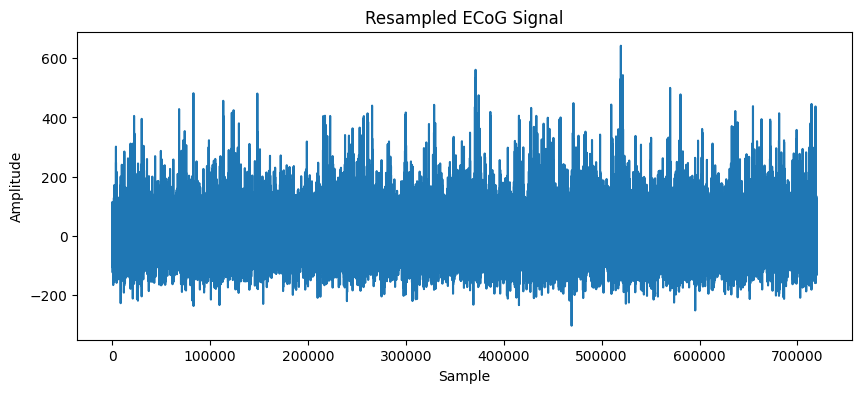

In [232]:
# target_samples = 60000
# current_samples = ecog_signal.shape[0]
# downsample_factor = current_samples // target_samples
# ecog_signal_resampled = scipy.signal.resample(ecog_signal, target_samples)

# plot resampled signal
plt.figure(figsize=(10, 4))
plt.plot(ecog_data[0])
plt.title('Resampled ECoG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Power spectrum 

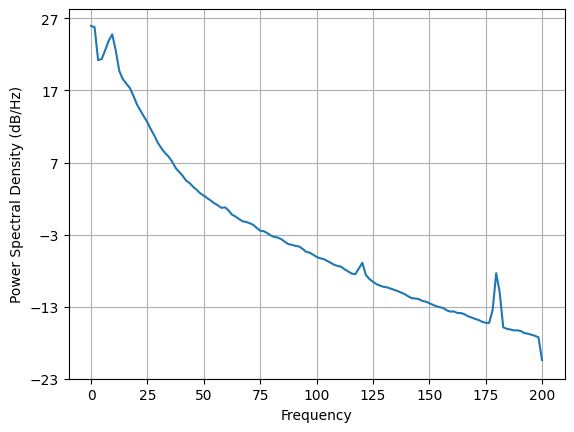

In [233]:
Pxx, freqs = plt.psd(ecog_data[0], Fs=raw_resampled.info['sfreq'])
plt.show()

# Filtering

1. notch filter line noise
2. plot PSD again to see they are removed
3. filter to high-gamma band (broadband) from 64-200 Hz

In [68]:
raw_resampled

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,1 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,0.00 Hz
Lowpass,200.00 Hz


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



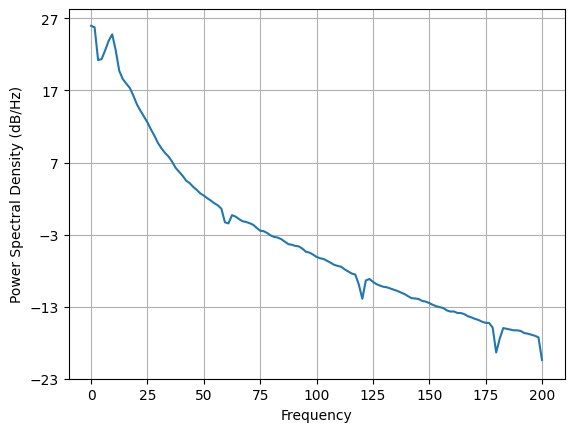

In [241]:
freqs = [60,120,180]

ecog_no_noise = raw_resampled.notch_filter(freqs)

Pxx, freqs = plt.psd(ecog_no_noise.get_data()[0], Fs=raw_resampled.info['sfreq']) 
#ravel works like squeeze, doesn't make copy
plt.show()

In [242]:
ecog_no_noise.get_data().shape

(2, 720001)

In [243]:
# extract high gammas (64-200)
ecog_filtered = ecog_no_noise.filter(l_freq=64, 
                                     h_freq=199, 
                                     method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB



In [244]:
ecog_filtered.info['sfreq']

400.0

In [245]:
raw_resampled.info['sfreq']

400.0

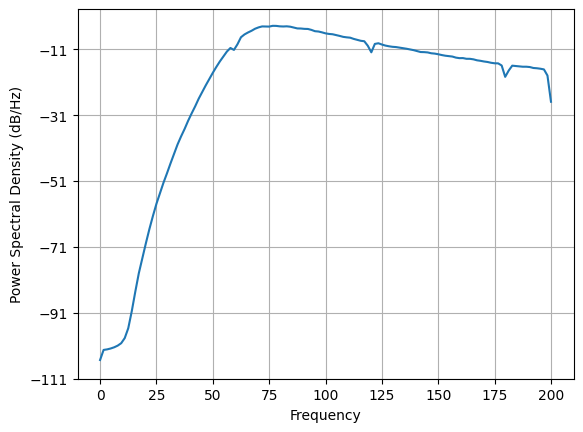

In [246]:
Pxx, freqs = plt.psd(ecog_filtered.get_data()[0], Fs=raw_resampled.info['sfreq']) 
plt.show()

In [247]:
ecog_filtered.get_data().shape

(2, 720001)

In [248]:
720001 / 400

1800.0025

## Next Steps

- [x] Slice 2 mins from the signal. How many samples = 2 mins?
- [x] 48,000 samples = 2 mins
- [x] Once have 2 min array, np.array_split(6) gives 6 20 sec arrays
- [x] Compute ACF (np.corr) for each of the 6 arrays
- [x] Compute ACW for each 
- [ ] Plot ACW values over time to see how width changes over time 

In [234]:
ecog_filtered.crop?

Signature: ecog_filtered.crop(tmin=0.0, tmax=None, include_tmax=True, *, verbose=None)
Docstring:
Crop raw data file.

Limit the data from the raw file to go between specific times. Note
that the new ``tmin`` is assumed to be ``t=0`` for all subsequently
called functions (e.g., :meth:`~mne.io.Raw.time_as_index`, or
:class:`~mne.Epochs`). New :term:`first_samp` and :term:`last_samp`
are set accordingly.

Thus function operates in-place on the instance.
Use :meth:`mne.io.Raw.copy` if operation on a copy is desired.

Parameters
----------

tmin : float
    Start time of the raw data to use in seconds (must be >= 0).

tmax : float
    End time of the raw data to use in seconds (cannot exceed data duration).

include_tmax : bool
    If True (default), include tmax. If False, exclude tmax (similar to how
    Python indexing typically works).

    .. versionadded:: 0.19

verbose : bool | str | int | None
    Control verbosity of the logging output. If ``None``, use the default
    verbosity l

In [249]:
new_raw = ecog_filtered.crop(tmin=0, tmax=120)
new_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,2 ECoG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,400.00 Hz
Highpass,64.00 Hz
Lowpass,199.00 Hz


In [25]:
# # slice 2 mins from signal, plot
# start_sample = 0
# end_sample = 48000
# data, times = ecog_filtered[:, start_sample:end_sample]

# # create a new Raw object with samples
# info = ecog_filtered.info.copy()
# new_raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=1, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   119.998 secs
Ready.


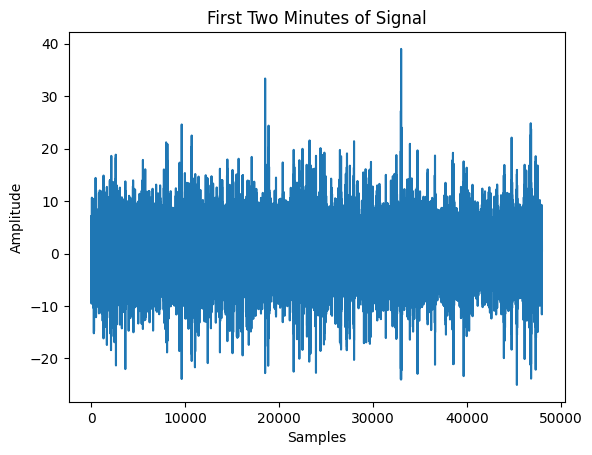

In [31]:
plt.plot(new_raw.get_data()[0])
plt.title('First Two Minutes of Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Reduce Signal Down to Two Minutes

In [235]:
np.array_split?

Signature:       np.array_split(ary, indices_or_sections, axis=0)
Call signature:  np.array_split(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function array_split at 0x1071ee5c0>
File:            ~/basicenv/lib/python3.11/site-packages/numpy/lib/shape_base.py
Docstring:      
Split an array into multiple sub-arrays.

Please refer to the ``split`` documentation.  The only difference
between these functions is that ``array_split`` allows
`indices_or_sections` to be an integer that does *not* equally
divide the axis. For an array of length l that should be split
into n sections, it returns l % n sub-arrays of size l//n + 1
and the rest of size l//n.

See Also
--------
split : Split array into multiple sub-arrays of equal size.

Examples
--------
>>> x = np.arange(8.0)
>>> np.array_split(x, 3)
[array([0.,  1.,  2.]), array([3.,  4.,  5.]), array([6.,  7.])]

>>> x = np.arange(9)
>>> np.array_split(x, 4)
[array([0, 1, 2]), array([3, 4]), array([5, 6]), array

In [250]:
new_raw.get_data().shape

(2, 48001)

In [252]:
# Array split to 20 secs
split_data = np.array_split(new_raw.get_data(), 6, axis=1)
print('Number of arrays:', len(split_data))
[e.shape for e in split_data]

Number of arrays: 6


[(2, 8001), (2, 8000), (2, 8000), (2, 8000), (2, 8000), (2, 8000)]

In [92]:
# from scipy.signal import correlate, correlation_lags, convolve, windows

# def ac_corr(
#     x: np.ndarray,
#     y: np.ndarray,
#     mode="same",
#     method="fft",
#     norm=True,
#     maxlags=None,
# ):
#     """General function to compute auto correlation using scipy

#     This function will center the data and normalize it by default.
#     """

#     # Center
#     x = x - x.mean()
#     y = y - y.mean()

#     # Correlate
#     corr = correlate(x, y, mode=mode, method=method)
#     lags = correlation_lags(x.size, y.size, mode=mode)
    
#     if norm:
#         corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

#     if maxlags is not None:
#         middle = (lags == 0).nonzero()[0].item()
#         lags = np.arange(-maxlags, maxlags + 1)
#         corr = corr[middle - maxlags : middle + maxlags + 1]

#     return corr, lags

# results = []
# time = []
# for i in range(len(split_data)):
#     chunk = split_data[i]
#     res, lag = ac_corr(chunk, chunk)
#     results.append(res)
#     time.append(lag)

# results = np.array(results)
# time = np.array(time)
# print(results.shape)
# print(time.shape)

(6, 8000)
(6, 8000)


## Autocorrelation Function

In [253]:
from scipy.signal import correlate, correlation_lags

def auto_corr(
    x: np.ndarray,
    y: np.ndarray,
    mode="same",
    method="fft",
    norm=True,
    maxlags=None
):
    """General function to compute auto correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    return corr, lags

In [261]:
corr_results = []
lag_results = []
for k in range(len(split_data)):
    sub_array = split_data[k]  # n_electrodes x time
    for h in sub_array:
        corr, lags = auto_corr(h, h)
        corr_results.append(corr)
        lag_results.append(lags)

results = corr_results # correlations
time = lag_results # time lags
# results.shape

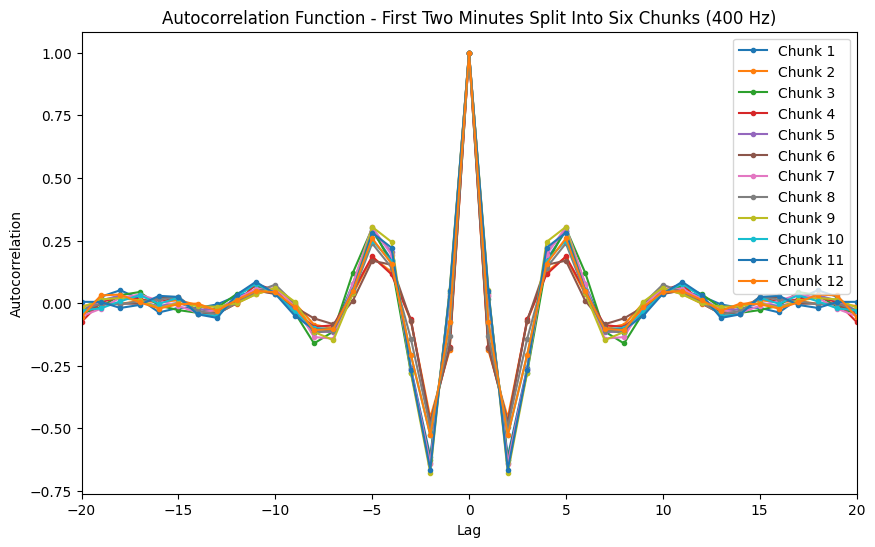

In [263]:
# plot each ACF result

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(results)): 
    ax.plot(time[i], results[i], label=f'Chunk {i+1}', marker='.')
    
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Function - First Two Minutes Split Into Six Chunks (400 Hz)')
ax.legend()
ax.set_xlim(0-20, 0+20)

plt.savefig('ACF_results.svg')
plt.show()

## Autocorrelation Width Function

In [127]:
# Compute ACW using Full Width Half Max

def calculate_half_width(acorr):
    max_value = np.max(acorr)
    half_max_value = max_value / 2.0
    indices_above_half_max = np.where(acorr >= half_max_value)[0]
    if len(indices_above_half_max) > 1:
        width = indices_above_half_max[-1] - indices_above_half_max[0]
    else:
        width = 0
    return width

# Calculate widths for each autocorrelation result
widths = [calculate_half_width(acorr) for acorr in results]

# Assume time points are sequential (1, 2, 3, ..., N)
time_points = np.arange(len(widths))

widths
# # Plot the widths over time
# plt.figure(figsize=(10, 5))
# plt.plot(time_points, widths, marker='o', linestyle='-')
# plt.xlabel('Time')
# plt.ylabel('Autocorrelation Width')
# plt.title('Autocorrelation Widths Over Time')

# plt.show()

[0, 0, 0, 0, 0, 0]

In [135]:
np.where(results[0] >= 0.5)[0]

array([4000])

Since the first two minutes of the ACF widths are the same as of now, there is no change in the ACW over time of 2 minutes.

In [264]:
# Gaussian dist of values for better FWHM plotting of points
from scipy.interpolate import UnivariateSpline

# create spline function
def spline_graph(t, r):
    spline = UnivariateSpline(time[0], results[0]-np.max(results[0])/2, s=0)
    r1, r2 = spline.roots() # find the roots
    return r1, r2

In [156]:
# append ACW of each chunk into array
ACWs = []

for i in range(results.shape[0]):
    r1, r2 = spline_graph(time[i], results[i].ravel())
    diff = r2 - r1
    ACWs.append(diff)

ACWs # convert to array later to plot other chunks over time [once it changes compared to two minutes]

[1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241,
 1.2547961243191241]

In [266]:
# ZZ suggestion:

ACWs = np.zeros((len(ecog_data), len(split_data)))
corr_results = []
lag_results = []

# split_data = [ (n_elec x samples) ]

# for each chunk in the 2-min
for i, chunk in enumerate(split_data):
    # chunk.shape = n_electrodes x time

    # for each electrode
    for j, electrode_chunk in enumerate(chunk):
        corr, lags = auto_corr(electrode_chunk, electrode_chunk)
        r1, r2 = spline_graph(lags, corr)
        fwhm = r2 - r1

        ACWs[j, i] = fwhm
        
        corr_results.append(corr)
        lag_results.append(lags)

results = corr_results # correlations
time = lag_results # time lags


In [270]:
ACWs.mean(axis=-1)

array([1.25487832, 1.25487832])

 The ACW for each of the 6 chunks is the same. This is to be expected because each chunk is the same on the plot.
 [Source](https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak) for spline function

## ACF on Final Two Minutes of Signal

Creating RawArray with float64 data, n_channels=1, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   119.998 secs
Ready.


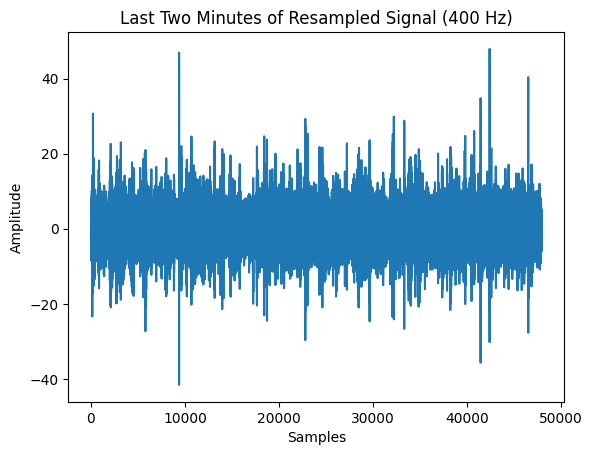

In [184]:
# slice last 2 mins from signal, plot
start_sample = 672001
end_sample = 720001
data, times = ecog_filtered[:, start_sample:end_sample]

# create a new Raw object with samples
info = ecog_filtered.info.copy()
end_raw = mne.io.RawArray(data, info)

plt.plot(end_raw.get_data().ravel())
plt.title('Last Two Minutes of Resampled Signal (400 Hz)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [185]:
# split into 20s chunks
split_end = np.array_split(end_raw.get_data().ravel(), 6)
print('Number of arrays:', len(split_end))
split_end

Number of arrays: 6


[array([ -0.23949783,  -2.82796803,   2.45830418, ...,  10.12926947,
          2.3251861 , -11.9356896 ]),
 array([-8.36773056, 10.67188065,  9.39994068, ..., -2.31111833,
         0.53745521,  2.47649403]),
 array([-0.29712467, -3.17683421, -1.75540192, ...,  0.5499849 ,
        -6.27590931, -1.31379733]),
 array([ 5.12495708,  2.97156135, -1.79001304, ..., -6.70018708,
        14.76042291,  2.07347974]),
 array([-10.9630504 ,  -7.7590209 ,  10.94314552, ...,   2.40920831,
          2.75641807,  -3.22672499]),
 array([-5.12198216,  3.48245047,  1.76292492, ...,  2.59596375,
        -4.46087412,  0.00716838])]

In [186]:
data = np.array(split_end) # convert to array

corr_results = []
lag_results = []
for k in range(data.shape[0]):
    sub_array = data[k]
    corr, lags = auto_corr(sub_array,sub_array)
    corr_results.append(corr)
    lag_results.append(lag)

results = np.array(corr_results) # correlations
time = np.array(lag_results) # time lags
results.shape

(6, 8000)

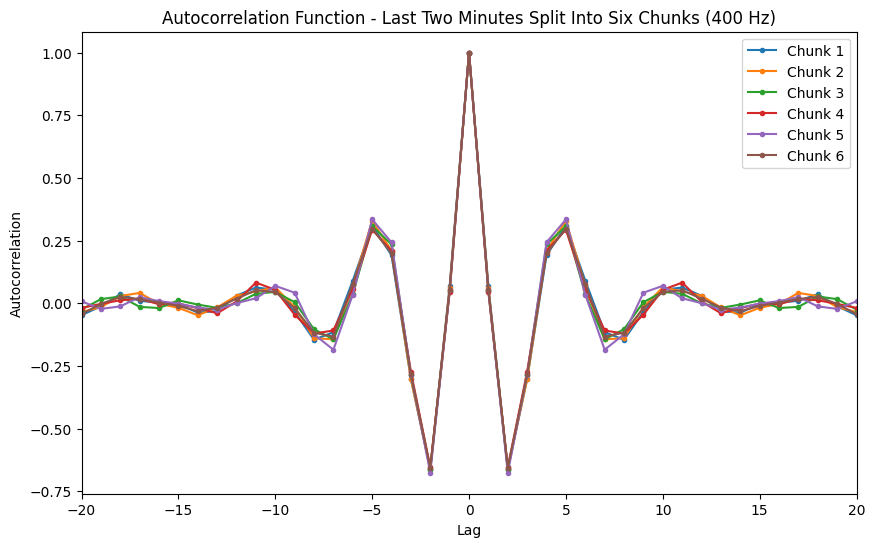

In [187]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(results.shape[0]):
    
    ax.plot(time[i], results[i].ravel(), label=f'Chunk {i+1}', marker='.')
    
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Function - Last Two Minutes Split Into Six Chunks (400 Hz)')
ax.legend()
ax.set_xlim(0-20, 0+20)

#plt.savefig('ACF_results.svg')
plt.show()

## Look at Other Electrodes

In [24]:
!ls -l /Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw

total 1849024
-rw-rw-r--  1 tevaughnshaw  staff  2771145 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_1.mat
-rw-rw-r--  1 tevaughnshaw  staff  4050087 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_10.mat
-rw-rw-r--  1 tevaughnshaw  staff  3389646 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_100.mat
-rw-rw-r--  1 tevaughnshaw  staff  3563590 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_101.mat
-rw-rw-r--  1 tevaughnshaw  staff  3731980 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_102.mat
-rw-rw-r--  1 tevaughnshaw  staff  3733803 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_103.mat
-rw-rw-r--  1 tevaughnshaw  staff  3937285 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_104.mat
-rw-rw-r--  1 tevaughnshaw  staff  3796792 Nov 25  2019 NY717_111_Part1_conversation1_electrode_raw_file_105.mat
-rw-rw-r--  1 tevaughnshaw  staff  4008572 Nov 25  2019 NY717_111_Part1_conversation1

## Analysis with New Electrode (File 101)

In [189]:
e101_dir = '/Volumes/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1/raw/NY717_111_Part1_conversation1_electrode_raw_file_101.mat'
mat = scipy.io.loadmat(e101_dir)
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Nov 25 17:33:55 2019',
 '__version__': '1.0',
 '__globals__': [],
 'electrode_data': array([[-43.4652781 , -33.62909895, -15.81763943, ...,  40.8068513 ,
          37.61673915,  22.7295491 ]])}

In [190]:
ecog_signal = mat['electrode_data'].ravel()  # for raw
ecog_signal.shape

(921601,)

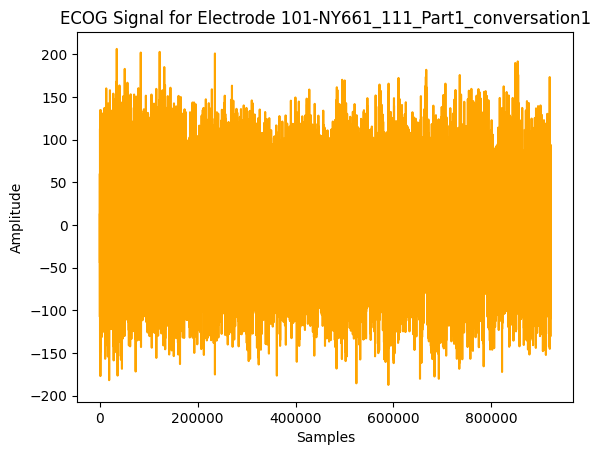

In [191]:
# plot electrode 101 original signal
plt.plot(ecog_signal, color='orange')
plt.title('ECOG Signal for Electrode 101-NY661_111_Part1_conversation1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [192]:
# create mne raw object using np array
sfreq = 512
info = mne.create_info(ch_names=['ECoG'],sfreq=sfreq, ch_types=['ecog'])
raw = mne.io.RawArray(ecog_signal.reshape(1, -1), info)

Creating RawArray with float64 data, n_channels=1, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


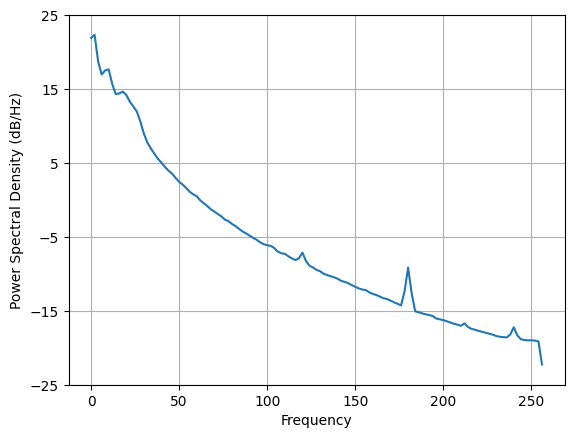

In [193]:
plt.psd(ecog_signal, Fs=raw.info['sfreq'])
plt.show()

## Downsample Electrode 101

In [194]:
new_sfreq = 400
raw_resampled = raw.copy().resample(new_sfreq)

In [195]:
ecog_data = raw_resampled.get_data()
ecog_data.shape

(1, 720001)

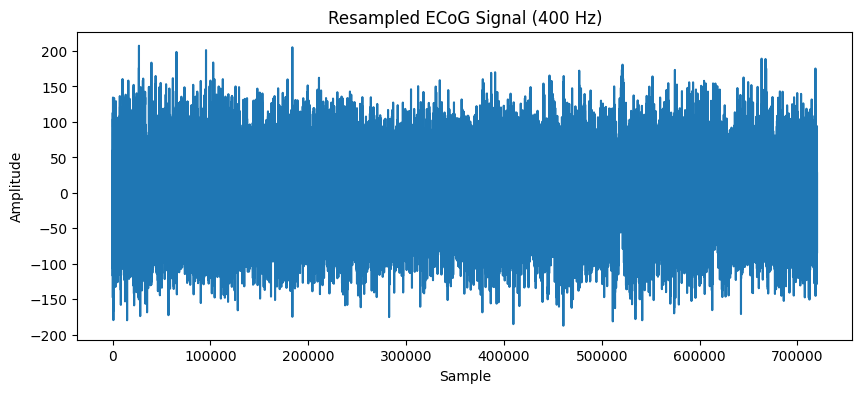

In [196]:
# plot resampled signal
plt.figure(figsize=(10, 4))
plt.plot(ecog_data.ravel())
plt.title('Resampled ECoG Signal (400 Hz)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

## Power Spectrum Electrode 101

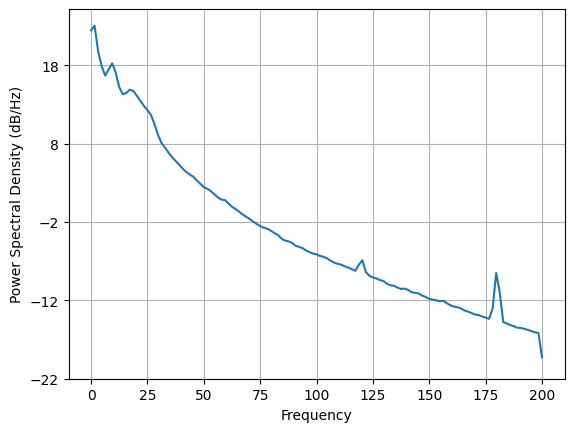

In [197]:
Pxx, freqs = plt.psd(ecog_data.ravel(), Fs=raw_resampled.info['sfreq'])
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 2641 samples (6.603 s)



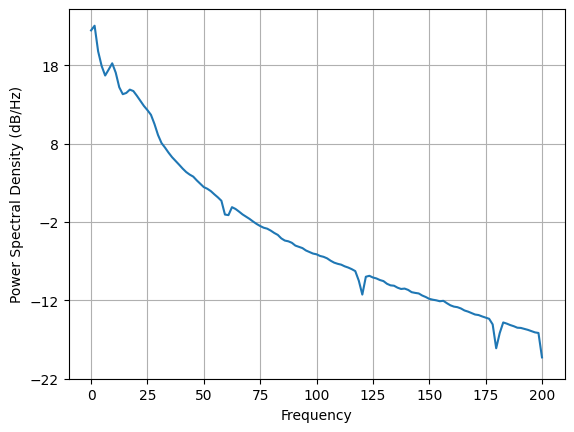

In [198]:
freqs = [60,120,180]

ecog_no_noise = raw_resampled.notch_filter(freqs)
Pxx, freqs = plt.psd(ecog_no_noise.get_data().ravel(), Fs=raw_resampled.info['sfreq']) 
#ravel works like squeeze, doesn't make copy
plt.show()

In [199]:
ecog_no_noise.get_data().shape

(1, 720001)

In [200]:
# extract high gammas (64-200)
ecog_filtered = ecog_no_noise.filter(l_freq=64, 
                                     h_freq=199, 
                                     method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 64 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.00, 199.00 Hz: -6.02, -6.02 dB



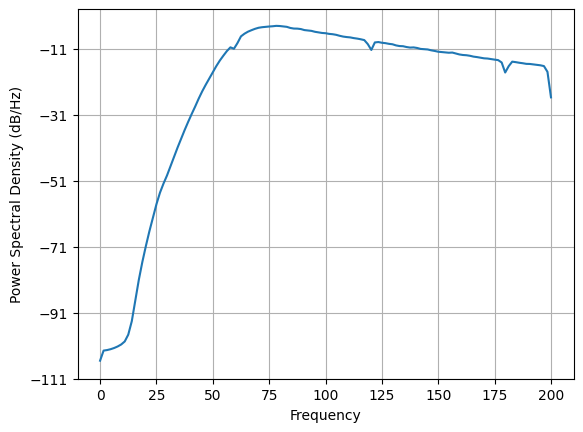

In [201]:
Pxx, freqs = plt.psd(ecog_filtered.get_data().ravel(), Fs=raw_resampled.info['sfreq']) 
plt.show()

In [203]:
# slice 2 mins from signal, plot
start_sample = 0
end_sample = 48000
data, times = ecog_filtered[:, start_sample:end_sample]

# create a new Raw object with samples
info = ecog_filtered.info.copy()
new_raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=1, n_times=48000
    Range : 0 ... 47999 =      0.000 ...   119.998 secs
Ready.


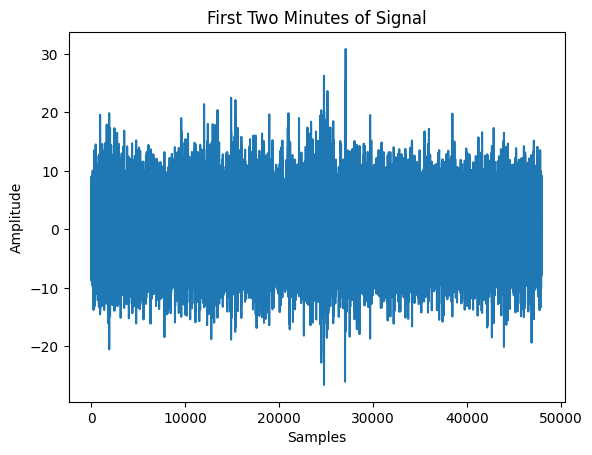

In [204]:
plt.plot(new_raw.get_data().ravel())
plt.title('First Two Minutes of Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Split Array into 20s Chunks

In [205]:
# Array split to 20 secs
split_data = np.array_split(new_raw.get_data().ravel(), 6)
print('Number of arrays:', len(split_data))
split_data

Number of arrays: 6


[array([ 1.11546468e-03, -5.24242488e+00,  2.16675952e+00, ...,
        -3.41892940e+00, -1.33097045e-01,  5.43984111e+00]),
 array([  1.6627615 ,  -7.21786594,   7.18687905, ...,  -1.02216155,
        -15.12718805,   6.15815252]),
 array([ 2.48593755, -2.97348714,  2.10693867, ..., -6.47818652,
         9.03427403, -1.86286104]),
 array([  8.33882202,  -1.51344924, -12.21970885, ..., -11.5357086 ,
         -0.25594324,   4.50066227]),
 array([ 3.78114696,  6.22802907, -7.97118469, ..., -3.92573679,
        -0.74620511,  2.22116121]),
 array([-3.36567667, -0.11190811,  5.70191573, ...,  1.48175861,
         0.30184745,  0.11420978])]

In [206]:
data = np.array(split_data) # convert to array

corr_results = []
lag_results = []
for k in range(data.shape[0]):
    sub_array = data[k]
    corr, lags = auto_corr(sub_array,sub_array)
    corr_results.append(corr)
    lag_results.append(lag)

results = np.array(corr_results) # correlations
time = np.array(lag_results) # time lags
results.shape

(6, 8000)

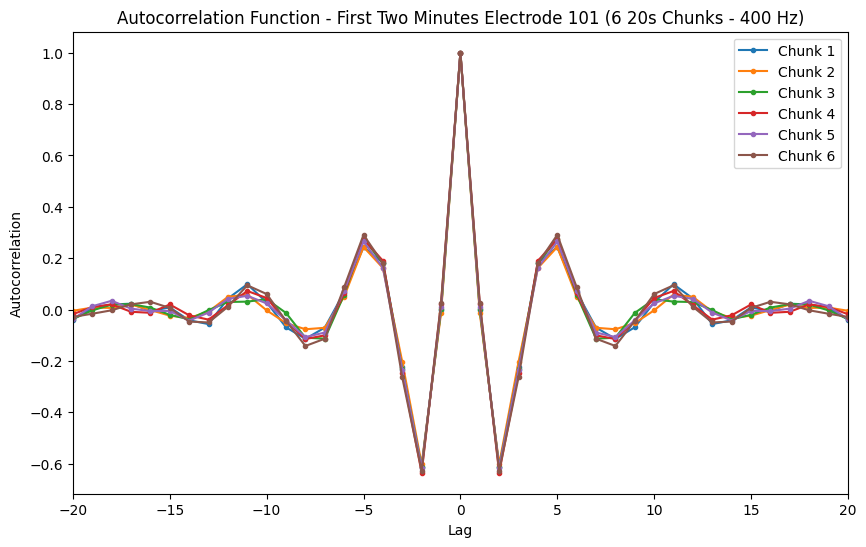

In [207]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(results.shape[0]):
    
    ax.plot(time[i], results[i].ravel(), label=f'Chunk {i+1}', marker='.')
    
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation Function - First Two Minutes Electrode 101 (6 20s Chunks - 400 Hz)')
ax.legend()
ax.set_xlim(0-20, 0+20)

plt.savefig('ACF_results.svg')
plt.show()

In [208]:
ACWs = []

for i in range(results.shape[0]):
    r1, r2 = spline_graph(time[i], results[i].ravel())
    diff = r2 - r1
    ACWs.append(diff)

ACWs

[1.237495162022836,
 1.237495162022836,
 1.237495162022836,
 1.237495162022836,
 1.237495162022836,
 1.237495162022836]

## Look at Other Patients

In [ ]:
# Autocorrelate 